**0) Data preprocessing**

In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline
from scipy.ndimage.filters import uniform_filter # smoothing images
from sklearn.linear_model import LinearRegression

In [3]:
# load csv
data = np.loadtxt('circadian_data/data141110.csv', delimiter=',', skiprows=1)

In [5]:
# reshaping each array (to make them work with sklearn)
# -1 is unknown dimension which numpy has to figure out, 1 is the other
image_no=data[:,0].reshape(-1,1)
frame_no=data[:,1].reshape(-1,1)
time_hrs=data[:,2].reshape(-1,1)
# check what python figured out as dimension for -1?
nb_images = data.shape[0]
nb_images # there are 1685 images

1685

In [6]:
# load images
flo_image_1 = np.load('circadian_data/flo_image_1.npz')
flo_image_2 = np.load('circadian_data/flo_image_2.npz')
# concatenate: join sequence of arrays along axis/ group data of both images
image_ids = np.concatenate([flo_image_1['image_ids'], flo_image_2['image_ids']])
images = np.concatenate([flo_image_1['image_stack'], flo_image_2['image_stack']])
# images aren't useful anymore
del flo_image_1, flo_image_2

In the following the kind of pictures we are working with can be seen. <br>
◦ optic nerve (bottom, cannot be seen)<br>
◦ suprachiasmatic nuclei (two bright ovals)<br>
◦ ventricle (top, vertical line)

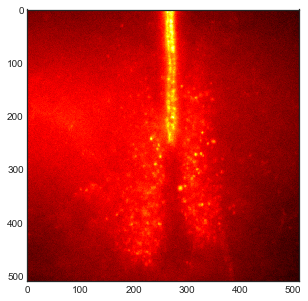

In [8]:
# plot an image out of 'image_stack's
fig = plt.figure(figsize = (5,5))
plt.imshow(images[1684], cmap='hot');

**1) How regular is the signal/ is the period 24 hours** <br>
Quantify regularity of periodic signal in general

a) Determine periods (23.4, 24.1, 25, 23.6,…)

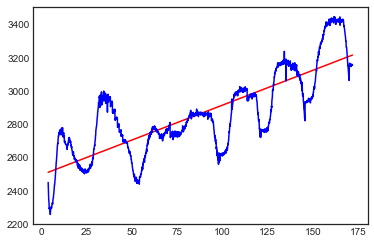

In [9]:
# mean intensity over time over entire image for each image 
mean_values = np.mean(images, axis=(1,2))

# linear regression
model = LinearRegression()
# fit model
model.fit(time_hrs, mean_values)
# predict model
mean_linear = model.predict(time_hrs)
# plot intensity against time, prediction against mean-values
plt.plot(time_hrs, model.predict(time_hrs), 'r')
plt.plot(time_hrs, mean_values, 'b')

# calculate norm-values for later, subtracting linear trend
norm_values = mean_values - mean_linear

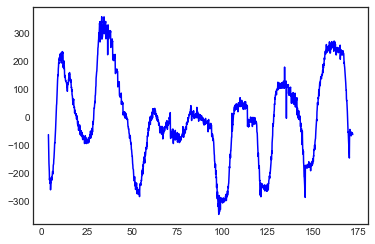

In [11]:
# plot norm values (after subtracting linear trend)
plt.plot(time_hrs, norm_values, 'b')

[[248 248 248 246 245 245 242 237 235 238 243 243 243 244 244 245]
 [247 247 246 246 246 244 243 238 235 240 243 243 243 244 245 245]
 [248 248 247 247 246 245 245 241 235 240 243 244 243 244 245 245]
 [247 248 247 246 245 245 245 242 233 241 243 243 244 245 245 245]
 [245 247 248 246 245 246 246 243 235 241 243 244 244 245 244 245]
 [245 247 246 245 243 246 247 244 235 243 243 244 244 244 244 245]
 [245 245 243 245 246 246 247 245 235 243 242 245 245 245 244 245]
 [247 247 245 245 247 247 246 245 240 241 243 244 245 245 244 244]
 [246 248 246 246 247 247 243 243 246 238 242 245 245 245 245 245]
 [248 248 247 247 246 245 239 237 242 236 235 243 243 245 245 245]
 [248 248 245 243 244 243 235 236 240 235 232 237 243 245 245 245]
 [248 247 248 245 244 238 232 231 237 230 226 230 241 245 245 245]
 [248 246 248 245 243 231 231 232 236 234 226 224 237 243 243 243]
 [248 246 245 243 240 226 227 234 237 236 233 226 231 239 241 242]
 [245 243 243 240 235 228 231 236 238 238 237 237 236 240 241 

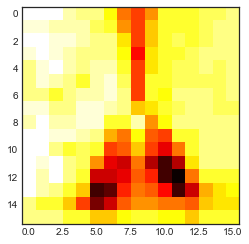

In [13]:
# functions from kernel "seeing the light v2" form kaggle

#function: removing the linear trend
def remove_linear_trend(time_series):
    x_axis = np.arange(len(time_series)).reshape(-1, 1)
    model = LinearRegression()
    model.fit(x_axis, time_series)
    return time_series - model.predict(x_axis)

#function: filtering
def filtered_acorr(time_series, high_pass=None, unbiased=True):
    """
    high_pass is a short 1D float array, 
    by which the low-frequency amplitudes are multiplied,
    e.g. high_pass = [0,0,0,0,0,0]
    """
    N = len(time_series)
    norm_values = remove_linear_trend(time_series)
    spectrum = np.fft.fft(norm_values, n=2*N)
    if high_pass is not None:
        spectrum[0] *= high_pass[0]
        for i in range(len(high_pass)):
            spectrum[i] *= high_pass[i]
            spectrum[-i] *= high_pass[i]
    acorr = np.real(np.fft.ifft(spectrum * np.conj(spectrum))[:N])
    if unbiased:
        return acorr / (N - np.arange(N))
    else:
        return acorr / N
    

#function: get period
def get_period(acorr):
    """
    Returns the index with largest acorr value, 
    after the first zero crossing.
    There are of course more sophisticated methods of doing this.
    """
    negative_periods = np.where(acorr <= 0.0)
    if negative_periods[0].size == 0:
        return 0
    first_zero = np.min(negative_periods)
    return first_zero + np.argmax(acorr[first_zero:])


#function: get grid periods
def get_grid_periods(images, box_size, max_period=300, high_pass=np.zeros((10,)), unbiased=False):
    """
    periods, acorrs = get_grid_periods(images, box_size, max_period=300, 
                                    high_pass=np.zeros((10,)), unbiased=False)
    Divides the image domain into small boxes of size box_size = (h,w) and computes
    the period over each of these small boxes."""
    h,w = box_size
    rows = images.shape[1] // h
    cols = images.shape[2] // w
    acorrs = np.empty((rows, cols, max_period), dtype = "float32")
    periods = np.empty((rows,cols, ), dtype = "int")
    for i in range(rows):
        for j in range(cols):
            time_series = np.mean(images[:, i*h:(i+1)*h, j*w:(j+1)*w], axis=(1,2))
            acorrs[i ,j] = filtered_acorr(time_series, high_pass = high_pass, 
                                          unbiased=unbiased)[:max_period]
            periods[i ,j] = get_period(acorrs[i, j])
    return periods, acorrs


# show periods array and periods in grid
periods, acorrs = get_grid_periods(images, (32, 32), max_period=1000, unbiased=False)
plt.imshow(periods, cmap='hot')
print(periods)

b) Compute standard deviation

In [22]:
#print period with better recognizable values
period_ten = periods/10
#print(period_ten)

#compute standard deviation with numpy to quantify the amount of variation in data
# low dev = data points tend to be close to mean (expected value)
# high dev = data points are spread out over wider range
per_dev = np.std(period_ten)
print('Standard deviation:', per_dev)

#expected value/mean
per_mean = np.mean(period_ten)
print('Mean period:', per_mean)

#min and max value in the array full of periods
per_min = np.amin(period_ten)
per_max = np.amax(period_ten)
print('Minimum period value:', per_min)
print('Maximum period value:', per_max)

Standard deviation: 0.498616096285
Mean period: 24.230859375
Minimum period value: 22.4
Maximum period value: 24.8


c) Using power spectrum (absolute value of FFT):<br>

Fast Fourier Transformation is a fast way to get the dominant period or frequency. It converts the signal in time spectrum to a frequency spectrum.

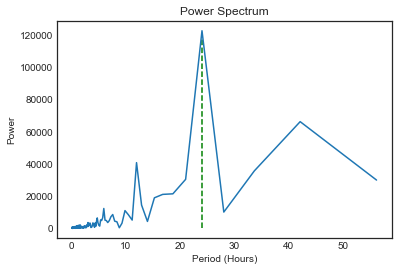

In [23]:
#take frequency that gives maximum value in graph, already given in kernel "seeing the light v2" on kaggle

# rfft calculates the fft in data for real input
spectrum = np.fft.rfft(norm_values)

# fftfreq computes frequencies associated with FFT components
# returns an array giving the frequencies of corresponding elements, ten image frames per hour
freq = np.fft.rfftfreq(len(norm_values), 1/10) #data size + time steps

# 1/freq = period
max_freq1 = 1.0 / freq[3:] 

#use absolute value of fft
max_freq2 = abs(spectrum[3:len(freq)])

# plot
plt.plot(max_freq1, max_freq2)
plt.vlines(24, ymin = 0, ymax= 120000, colors = 'g', linewidth=1.5, linestyles = 'dashed')
plt.xlabel('Period (Hours)')
plt.ylabel('Power')
plt.title('Power Spectrum');

In [24]:
# the x-value at maximum y-value
#*1000 to set it to same values as on y-axis
max_freq_x = freq[max_freq2.argmax()]*1000
print(max_freq_x)

23.7388724036


FFT shows that the dominant period is 23.7, so approximatately the expected 24 hours.

**2) Regularity of periodic signal in each cluster**<br>

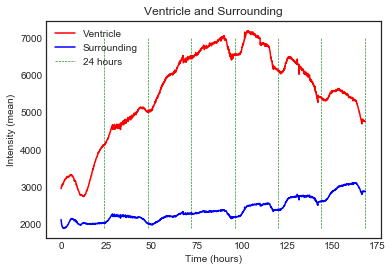

In [25]:
# Non-periodic parts
# load cluster data 
ventricle = np.loadtxt('cluster_dict_0.txt', delimiter='/n')
outside = np.loadtxt('cluster_dict_3.txt', delimiter='/n')

fig, ax = plt.subplots()

#change labels on x-axis manually
xaxis_label = ['0','0','25','50','75', '100', '125', '150', '175']

ax.set_xticklabels(xaxis_label)

#set 24 hour separations
vline_label = [240, 480, 720, 960, 1200, 1440, 1680]

#plot
plt.plot(ventricle, 'r', label = 'Ventricle')
plt.plot(outside, 'b', label = 'Surrounding')
plt.title('Ventricle and Surrounding')
plt.xlabel('Time (hours)')
plt.ylabel('Intensity (mean)')
#draw vertical lines every 24hours on x-axis to see the pattern
plt.vlines(vline_label, ymin = 1900, ymax= 7000, colors = 'g', linewidth=0.6, linestyles = 'dashed', label = '24 hours')
plt.legend();
plt.show()

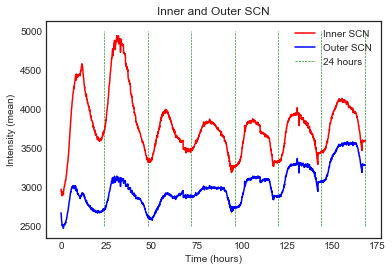

In [26]:
# Periodic parts
# load cluster data 
scn_in = np.loadtxt('cluster_dict_2.txt', delimiter='/n')
scn_out = np.loadtxt('cluster_dict_1.txt', delimiter='/n')

fig, ax = plt.subplots()

#change labels on x-axis manually
xaxis_label = ['0','0','25','50','75', '100', '125', '150', '175']

ax.set_xticklabels(xaxis_label)

#set 24 hour separations
vline_label = [240, 480, 720, 960, 1200, 1440, 1680]

#plot
plt.plot(scn_in, 'r', label = 'Inner SCN')
plt.plot(scn_out, 'b', label = 'Outer SCN')
plt.title('Inner and Outer SCN')
plt.xlabel('Time (hours)')
plt.ylabel('Intensity (mean)')
#draw vertical lines every 24hours on x-axis to see the pattern
plt.vlines(vline_label, ymin = 2500, ymax= 5000, colors = 'g', linewidth=0.6, linestyles = 'dashed', label = '24 hours')
plt.legend();
plt.show()

**3) Understand how neural network synchronizes the circadian clock of individual neurons**<br>

Quantify, if different periodic signals peak (obtain their maximum) at the same time or is there some lag or phase difference (when one obtains the maximum other signals are shifted or obtain their maximum a bit later)

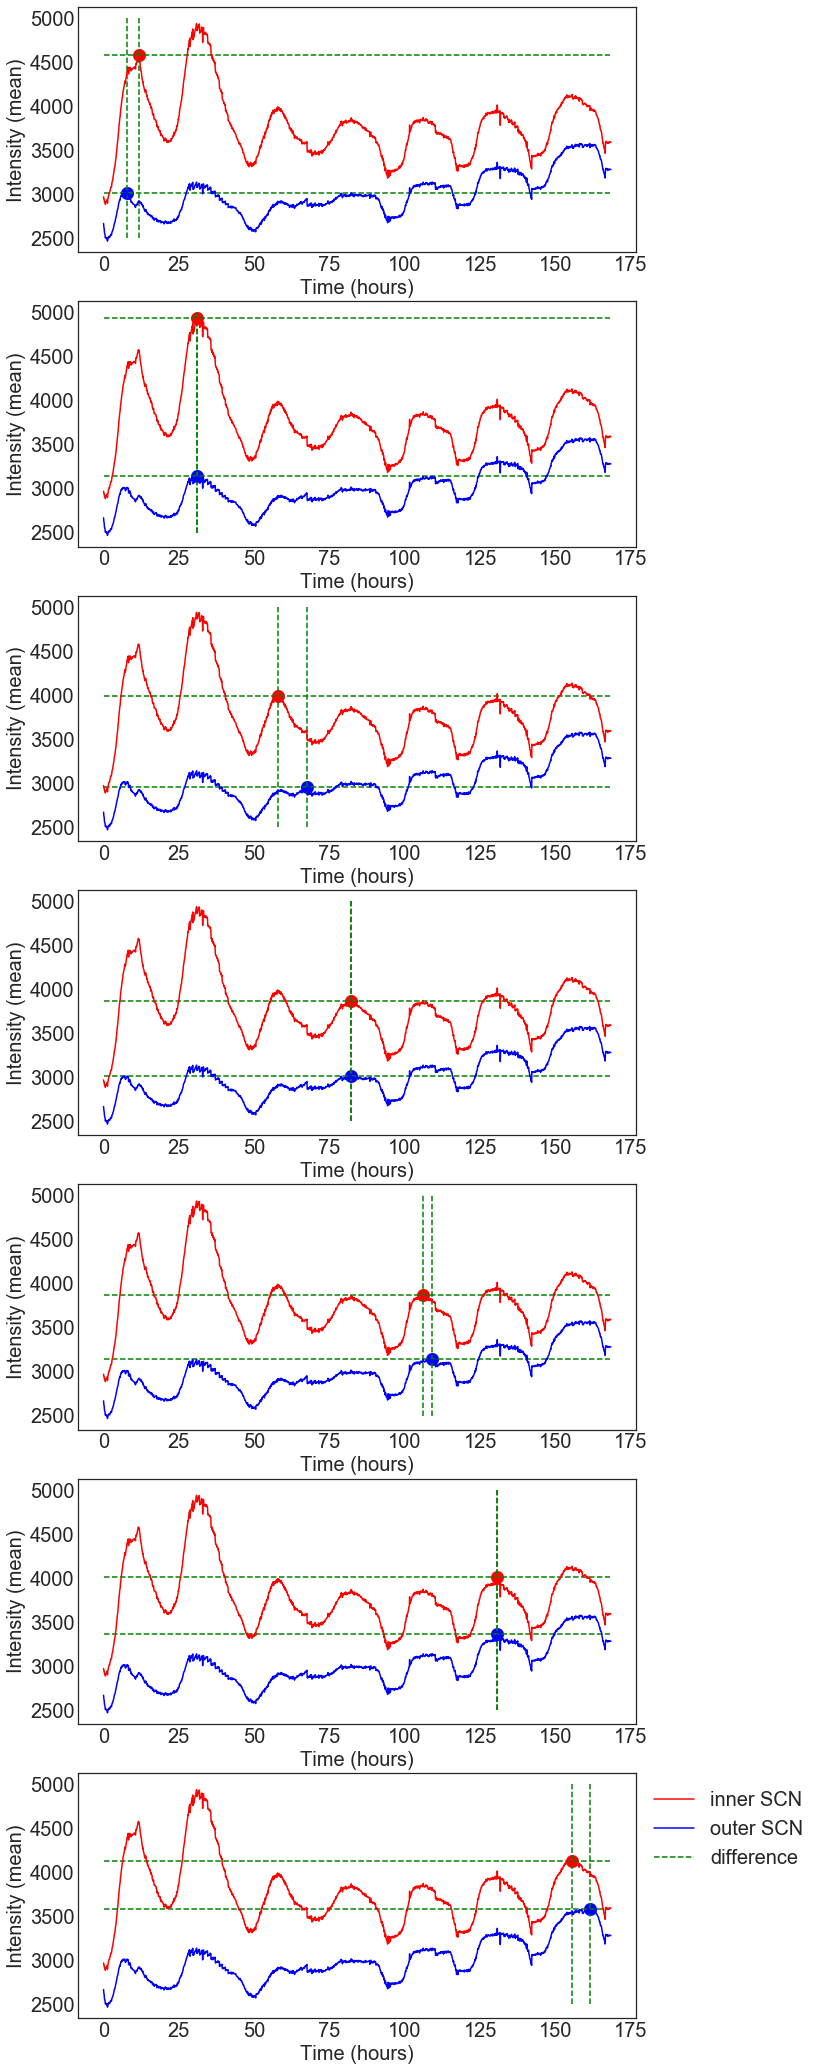

In [27]:
# predefined lists for peaks
peak_in_x= []
peak_in_y= []

peak_out_x=[]
peak_out_y=[]

# loop for setting to actual peak and append to empty lists
for i in range(0, 1680, 240):
    j = i+240
    peak_in_x.append(i+np.argmax(scn_in[i:j]))
    peak_in_y.append(max(scn_in[i:j]))
    peak_out_x.append(i+np.argmax(scn_out[i:j]))
    peak_out_y.append(max(scn_out[i:j]))
    
# axis labels
xaxis_label = ['0','0','25','50','75', '100', '125', '150', '175'] 
yaxis_label = ['2500', '2500', '3000', '3500', '4000', '4500', '5000']


fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize=(10,37))

# plottings subplots for each peak
# for sure the code for this part could be shorter

ax1.plot(scn_in, 'r', label = 'inner SCN')
ax1.plot(scn_out, 'b', label = 'outer SCN')
ax1.set_xticklabels(xaxis_label, fontsize=20)
ax1.set_yticklabels(yaxis_label, fontsize=20)
#ax1.set_title('SCN inner and outer part')
ax1.set_xlabel('Time (hours)', fontsize=20)
ax1.set_ylabel('Intensity (mean)', fontsize=20)
ax1.scatter(peak_in_x[0], peak_in_y[0], color='red', linewidth=7)
ax1.scatter(peak_out_x[0], peak_out_y[0], color='blue', linewidth=7)
ax1.vlines(peak_in_x[0], ymin = 2500, ymax= 5000, colors = 'g', linewidth=1.5, linestyles = 'dashed', label = 'difference')
ax1.vlines(peak_out_x[0], ymin = 2500, ymax= 5000, colors = 'g', linewidth=1.5, linestyles = 'dashed')
ax1.hlines(peak_in_y[0], xmin = 0, xmax= 1680, colors = 'g', linewidth=1.5, linestyles = 'dashed')
ax1.hlines(peak_out_y[0], xmin = 0, xmax= 1680, colors = 'g', linewidth=1.5, linestyles = 'dashed')

ax2.plot(scn_in, 'r', label = 'inner SCN')
ax2.plot(scn_out, 'b', label = 'outer SCN')
ax2.set_xticklabels(xaxis_label, fontsize=20)
ax2.set_yticklabels(yaxis_label, fontsize=20)
#ax1.set_title('SCN inner and outer part')
ax2.set_xlabel('Time (hours)', fontsize=20)
ax2.set_ylabel('Intensity (mean)', fontsize=20)
ax2.scatter(peak_in_x[1], peak_in_y[1], color='red', linewidth=7)
ax2.scatter(peak_out_x[1], peak_out_y[1], color='blue', linewidth=7)
ax2.vlines(peak_in_x[1], ymin = 2500, ymax= 5000, colors = 'g', linewidth=1.5, linestyles = 'dashed', label = 'difference')
ax2.vlines(peak_out_x[1], ymin = 2500, ymax= 5000, colors = 'g', linewidth=1.5, linestyles = 'dashed')
ax2.hlines(peak_in_y[1], xmin = 0, xmax= 1680, colors = 'g', linewidth=1.5, linestyles = 'dashed')
ax2.hlines(peak_out_y[1], xmin = 0, xmax= 1680, colors = 'g', linewidth=1.5, linestyles = 'dashed')

ax3.plot(scn_in, 'r', label = 'inner SCN')
ax3.plot(scn_out, 'b', label = 'outer SCN')
ax3.set_xticklabels(xaxis_label, fontsize=20)
ax3.set_yticklabels(yaxis_label, fontsize=20)
#ax1.set_title('SCN inner and outer part')
ax3.set_xlabel('Time (hours)', fontsize=20)
ax3.set_ylabel('Intensity (mean)', fontsize=20)
ax3.scatter(peak_in_x[2], peak_in_y[2], color='red', linewidth=7)
ax3.scatter(peak_out_x[2], peak_out_y[2], color='blue', linewidth=7)
ax3.vlines(peak_in_x[2], ymin = 2500, ymax= 5000, colors = 'g', linewidth=1.5, linestyles = 'dashed', label = 'difference')
ax3.vlines(peak_out_x[2], ymin = 2500, ymax= 5000, colors = 'g', linewidth=1.5, linestyles = 'dashed')
ax3.hlines(peak_in_y[2], xmin = 0, xmax= 1680, colors = 'g', linewidth=1.5, linestyles = 'dashed')
ax3.hlines(peak_out_y[2], xmin = 0, xmax= 1680, colors = 'g', linewidth=1.5, linestyles = 'dashed')

ax4.plot(scn_in, 'r', label = 'inner SCN')
ax4.plot(scn_out, 'b', label = 'outer SCN')
ax4.set_xticklabels(xaxis_label, fontsize=20)
ax4.set_yticklabels(yaxis_label, fontsize=20)
#ax1.set_title('SCN inner and outer part')
ax4.set_xlabel('Time (hours)', fontsize=20)
ax4.set_ylabel('Intensity (mean)', fontsize=20)
ax4.scatter(peak_in_x[3], peak_in_y[3], color='red', linewidth=7)
ax4.scatter(peak_out_x[3], peak_out_y[3], color='blue', linewidth=7)
ax4.vlines(peak_in_x[3], ymin = 2500, ymax= 5000, colors = 'g', linewidth=1.5, linestyles = 'dashed', label = 'difference')
ax4.vlines(peak_out_x[3], ymin = 2500, ymax= 5000, colors = 'g', linewidth=1.5, linestyles = 'dashed')
ax4.hlines(peak_in_y[3], xmin = 0, xmax= 1680, colors = 'g', linewidth=1.5, linestyles = 'dashed')
ax4.hlines(peak_out_y[3], xmin = 0, xmax= 1680, colors = 'g', linewidth=1.5, linestyles = 'dashed')

ax5.plot(scn_in, 'r', label = 'inner SCN')
ax5.plot(scn_out, 'b', label = 'outer SCN')
ax5.set_xticklabels(xaxis_label, fontsize=20)
ax5.set_yticklabels(yaxis_label, fontsize=20)
#ax1.set_title('SCN inner and outer part')
ax5.set_xlabel('Time (hours)', fontsize=20)
ax5.set_ylabel('Intensity (mean)', fontsize=20)
ax5.scatter(peak_in_x[4], peak_in_y[4], color='red', linewidth=7)
ax5.scatter(peak_out_x[4], peak_out_y[4], color='blue', linewidth=7)
ax5.vlines(peak_in_x[4], ymin = 2500, ymax= 5000, colors = 'g', linewidth=1.5, linestyles = 'dashed', label = 'difference')
ax5.vlines(peak_out_x[4], ymin = 2500, ymax= 5000, colors = 'g', linewidth=1.5, linestyles = 'dashed')
ax5.hlines(peak_in_y[4], xmin = 0, xmax= 1680, colors = 'g', linewidth=1.5, linestyles = 'dashed')
ax5.hlines(peak_out_y[4], xmin = 0, xmax= 1680, colors = 'g', linewidth=1.5, linestyles = 'dashed')

ax6.plot(scn_in, 'r', label = 'inner SCN')
ax6.plot(scn_out, 'b', label = 'outer SCN')
ax6.set_xticklabels(xaxis_label, fontsize=20)
ax6.set_yticklabels(yaxis_label, fontsize=20)
#ax1.set_title('SCN inner and outer part')
ax6.set_xlabel('Time (hours)', fontsize=20)
ax6.set_ylabel('Intensity (mean)', fontsize=20)
ax6.scatter(peak_in_x[5], peak_in_y[5], color='red', linewidth=7)
ax6.scatter(peak_out_x[5], peak_out_y[5], color='blue', linewidth=7)
ax6.vlines(peak_in_x[5], ymin = 2500, ymax= 5000, colors = 'g', linewidth=1.5, linestyles = 'dashed', label = 'difference')
ax6.vlines(peak_out_x[5], ymin = 2500, ymax= 5000, colors = 'g', linewidth=1.5, linestyles = 'dashed')
ax6.hlines(peak_in_y[5], xmin = 0, xmax= 1680, colors = 'g', linewidth=1.5, linestyles = 'dashed')
ax6.hlines(peak_out_y[5], xmin = 0, xmax= 1680, colors = 'g', linewidth=1.5, linestyles = 'dashed')

ax7.plot(scn_in, 'r', label = 'inner SCN')
ax7.plot(scn_out, 'b', label = 'outer SCN')
ax7.set_xticklabels(xaxis_label, fontsize=20)
ax7.set_yticklabels(yaxis_label, fontsize=20)
#ax1.set_title('SCN inner and outer part')
ax7.set_xlabel('Time (hours)', fontsize=20)
ax7.set_ylabel('Intensity (mean)', fontsize=20)
ax7.scatter(peak_in_x[6], peak_in_y[6], color='red', linewidth=7)
ax7.scatter(peak_out_x[6], peak_out_y[6], color='blue', linewidth=7)
ax7.vlines(peak_in_x[6], ymin = 2500, ymax= 5000, colors = 'g', linewidth=1.5, linestyles = 'dashed', label = 'difference')
ax7.vlines(peak_out_x[6], ymin = 2500, ymax= 5000, colors = 'g', linewidth=1.5, linestyles = 'dashed')
ax7.hlines(peak_in_y[6], xmin = 0, xmax= 1680, colors = 'g', linewidth=1.5, linestyles = 'dashed')
ax7.hlines(peak_out_y[6], xmin = 0, xmax= 1680, colors = 'g', linewidth=1.5, linestyles = 'dashed')

# insert legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=20);
plt.show()

In [28]:
#create a dataframe with the peak-lists from above
df_calc = pd.DataFrame({'Peak inner X':peak_in_x,'Peak outer X': peak_out_x,'Peak inner Y': peak_in_y, 'Peak outer Y': peak_out_y})
df_calc

,Peak inner X,Peak outer X,Peak inner Y,Peak outer Y
0,116,78,4577.0,3014.0
1,309,309,4937.0,3138.0
2,578,675,3992.0,2952.0
3,822,822,3868.0,3017.0
4,1061,1091,3872.0,3139.0
5,1307,1307,4014.0,3363.0
6,1555,1614,4133.0,3577.0


In [29]:
#change the scale/unit of the numbers
df_calc['Peak inner X'] = df_calc['Peak inner X'] / 10
df_calc['Peak outer X'] = df_calc['Peak outer X'] / 10
df_calc

,Peak inner X,Peak outer X,Peak inner Y,Peak outer Y
0,11.6,7.8,4577.0,3014.0
1,30.9,30.9,4937.0,3138.0
2,57.8,67.5,3992.0,2952.0
3,82.2,82.2,3868.0,3017.0
4,106.1,109.1,3872.0,3139.0
5,130.7,130.7,4014.0,3363.0
6,155.5,161.4,4133.0,3577.0


In [30]:
# Calculate peak differences in time and intensity
df_calc['Difference in Time (X)'] = abs(df_calc['Peak inner X'] - df_calc['Peak outer X'])
df_calc['Difference in Intensity (Y)'] = abs(df_calc['Peak inner Y'] - df_calc['Peak outer Y'])

df_calc

,Peak inner X,Peak outer X,Peak inner Y,Peak outer Y,Difference in Time (X),Difference in Intensity (Y)
0,11.6,7.8,4577.0,3014.0,3.8,1563.0
1,30.9,30.9,4937.0,3138.0,0.0,1799.0
2,57.8,67.5,3992.0,2952.0,9.7,1040.0
3,82.2,82.2,3868.0,3017.0,0.0,851.0
4,106.1,109.1,3872.0,3139.0,3.0,733.0
5,130.7,130.7,4014.0,3363.0,0.0,651.0
6,155.5,161.4,4133.0,3577.0,5.9,556.0
